# 🧠 Brain Tumor Detection in MRI Scans

<p align="center">
  <img src="brain-tumor-fig1.jpg" alt="Brain Tumor MRI" width="500"/>
</p>

<hr style="border:1px solid lightgray">

## 📝 Project Overview

Early detection of brain tumors can significantly improve patient outcomes. In this project, we build a deep learning model to classify brain MRI scans into four categories.

We follow a two-step modeling approach:
- First, we design and train a custom Convolutional Neural Network (CNN) from scratch.
- Then, we apply transfer learning using a pretrained VGG16 model.

Finally, we compare both models' performance and deploy the best one using a simple Streamlit application.

**Objectives**:
- Understand and prepare the MRI dataset
- Train a CNN model from scratch
- Apply transfer learning with VGG16
- Compare performance (accuracy, loss, confusion matrix)
- Deploy the best model for real-time prediction

---


# 📂 About the Dataset

We are using a **Brain MRI dataset** that contains **four categories** of images:

✅ **Glioma Tumor** – A type of tumor that occurs in the brain or spinal cord.  
✅ **Meningioma Tumor** – A slow-growing tumor that forms on membranes surrounding the brain and spinal cord.  
✅ **Pituitary Tumor** – A growth in the pituitary gland affecting hormone production.  
✅ **No Tumor** – Healthy MRI scans without any tumor.

---

This dataset consists of **labeled MRI images** that will be used to **train, validate, and test** our model.


<h3 style="text-decoration: underline;">📚 Importing Libraries</h3>





In [278]:
import os
import plotly.express as px
import cv2
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
import hashlib
import random
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from PIL import Image, ImageEnhance
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# 1. 📊 Data Understanding

## 1.1 📂 Load & Explore the Data

In this section, we explore the **Brain MRI** dataset to understand its structure and contents.

We aim to:
- Visualize the dataset organization (Training and Testing sets)
- Display the number of images available per class
- Show sample MRI images for each tumor type
- Understand the classification categories


In [23]:
# 📂 Defining dataset paths

train_dir = r'C:\Users\MYPC\Downloads\archive (8)\Training'
test_dir = r'C:\Users\MYPC\Downloads\archive (8)\Testing'
train_counts = {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in classes}
test_counts = {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in classes}
# Check the categories (folders inside Training set)
classes = os.listdir(train_dir)
print(f"Classes found in the dataset: {classes}")
    

Classes found in the dataset: ['glioma', 'meningioma', 'notumor', 'pituitary']


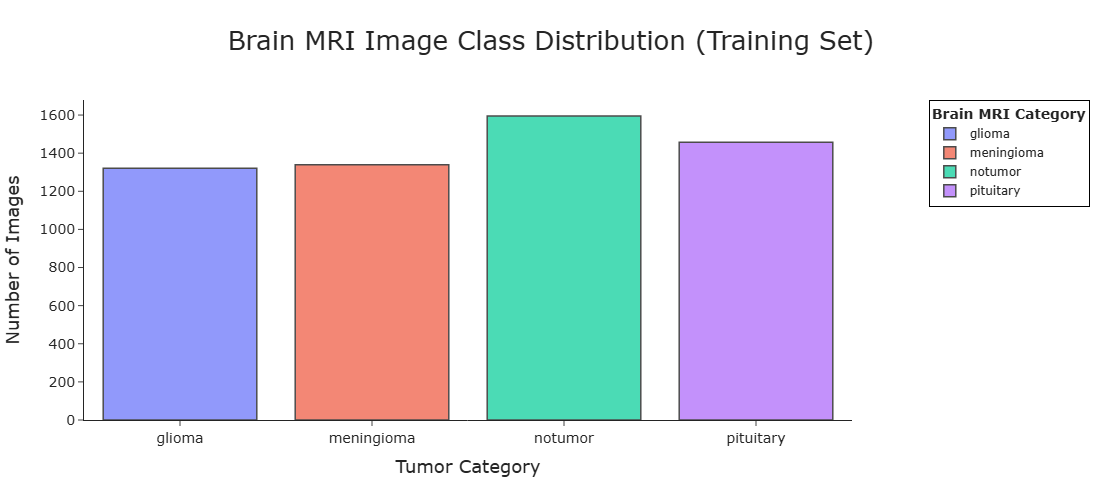

In [27]:
fig = go.Figure()

colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA']  # Different colors for each class

# Loop over each class to create a separate bar
for cls, color in zip(train_counts.keys(), colors):
    fig.add_trace(go.Bar(
        x=[cls],
        y=[train_counts[cls]],
        name=cls,                           # <--- This creates the correct legend!
        marker_color=color,
        hovertemplate='<b>%{x}</b><br>Number of Images: %{y}<extra></extra>'
    ))

# Update layout
fig.update_layout(
    title="Brain MRI Image Class Distribution (Training Set)",
    title_x=0.5,
    title_font=dict(size=26),
    xaxis_title="Tumor Category",
    yaxis_title="Number of Images",
    xaxis=dict(title_font=dict(size=18), tickfont=dict(size=14)),
    yaxis=dict(title_font=dict(size=18), tickfont=dict(size=14)),
    template="simple_white",
    showlegend=True,
    legend=dict(
        title=dict(text='<b>Brain MRI Category</b>'),  # Bold legend title
        x=1.1,            # Move legend to right
        y=1,
        bgcolor="rgba(0,0,0,0)",  # Transparent background
        bordercolor="black",
        borderwidth=1
    ),
    height=500,
    width=900
)

# Add styles to the bars
fig.update_traces(
    marker_line_color='black',
    marker_line_width=1.5,
    opacity=0.7    # Soft colors
)

fig.show()


### 📊 Training Set Class Distribution

The bar chart above illustrates the distribution of MRI brain images across four tumor categories in the **Training Set**:

- **Glioma**
- **Meningioma**
- **No Tumor**
- **Pituitary**

Each bar represents the number of images available for a specific category.  

✅ The dataset shows a **relatively balanced distribution** among the classes, with no significant overrepresentation of any single tumor type.  
✅ This balance is crucial to ensure that the CNN model trained later does not develop a bias towards any specific category.  
✅ A well-distributed training dataset typically leads to better model generalization and improved overall performance.

> **Key Insight:**  
> The training data is sufficiently balanced to proceed with model training without major concerns regarding class imbalance.


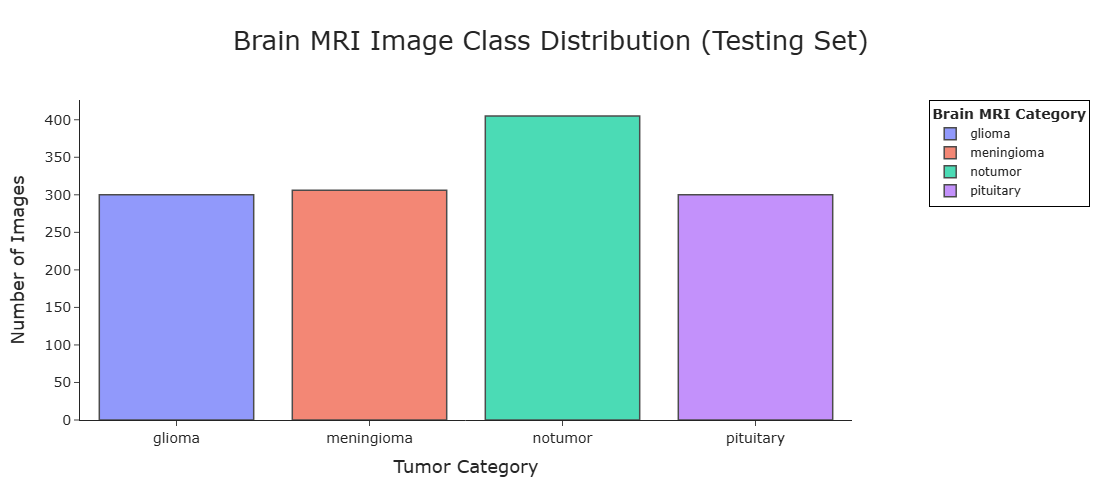

In [29]:
fig = go.Figure()

colors = ['#636EFA', '#EF553B', '#00CC96', '#AB63FA']  # Same colors for consistency

# Loop over each class to create a separate bar
for cls, color in zip(test_counts.keys(), colors):
    fig.add_trace(go.Bar(
        x=[cls],
        y=[test_counts[cls]],
        name=cls,                           # <--- Same class names
        marker_color=color,
        hovertemplate='<b>%{x}</b><br>Number of Images: %{y}<extra></extra>'
    ))

# Update layout
fig.update_layout(
    title="Brain MRI Image Class Distribution (Testing Set)",  # <-- Title changed!
    title_x=0.5,
    title_font=dict(size=26),
    xaxis_title="Tumor Category",
    yaxis_title="Number of Images",
    xaxis=dict(title_font=dict(size=18), tickfont=dict(size=14)),
    yaxis=dict(title_font=dict(size=18), tickfont=dict(size=14)),
    template="simple_white",
    showlegend=True,
    legend=dict(
        title=dict(text='<b>Brain MRI Category</b>'),
        x=1.1,
        y=1,
        bgcolor="rgba(0,0,0,0)",
        bordercolor="black",
        borderwidth=1
    ),
    height=500,
    width=900
)

# Add styles to the bars
fig.update_traces(
    marker_line_color='black',
    marker_line_width=1.5,
    opacity=0.7
)

fig.show()


**Observation:**  
The Testing Set shows a relatively balanced distribution across tumor categories, similar to the Training Set.


## 1.2 🖼️ Visualize Sample MRI Images

In this section, we display a few randomly selected MRI images from each tumor category to gain a better understanding of the dataset.

Each image corresponds to one of the four classes:  
**Glioma Tumor**, **Meningioma Tumor**, **Pituitary Tumor**, or **No Tumor**.


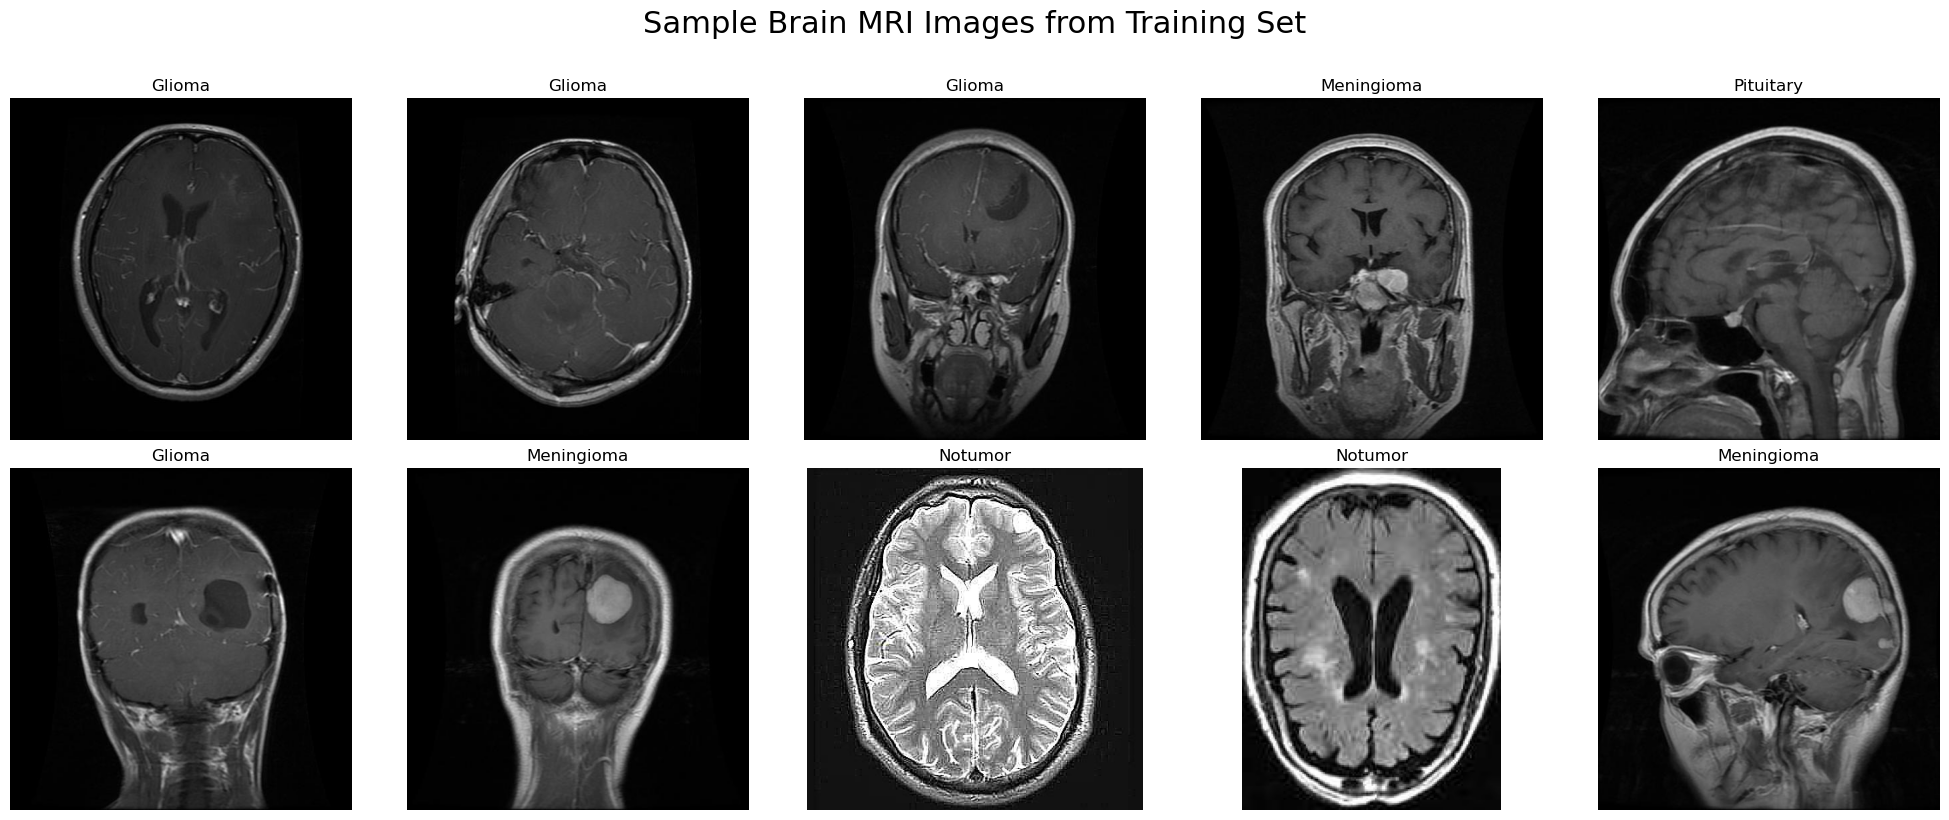

In [37]:
# 📸 Display 10 Random Sample Images from Training Set

fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows, 5 columns
axes = axes.flatten()

# Collect all images across classes
all_images = []
for cls in classes:
    class_path = os.path.join(train_dir, cls)
    images = os.listdir(class_path)
    for img_name in images:
        all_images.append((cls, os.path.join(class_path, img_name)))

# Randomly select 10 images
random_samples = random.sample(all_images, 10)

# Display the images
for idx, (cls, img_path) in enumerate(random_samples):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axes[idx].imshow(img)
    axes[idx].set_title(cls.capitalize(), fontsize=12)
    axes[idx].axis('off')

plt.suptitle('Sample Brain MRI Images from Training Set', fontsize=22, y=1.02)
plt.tight_layout()
plt.show()


# 1.3 🧠 Dataset Technical Analysis

Before applying any preprocessing techniques, it is crucial to technically examine the dataset.  
This ensures that we design the preprocessing pipeline appropriately for the models we will train later.

In this section, we will:
- 📏 Analyze the original dimensions of the MRI images
- 🎨 Verify the number of color channels in the images


## 1.3.1 📏 Image Dimension Analysis

Deep learning models require input images to have a uniform size.  
Thus, understanding the natural dimensions of the MRI images is an essential first step.

Here, we analyze the minimum and maximum widths and heights across a random sample of the dataset.


In [49]:
widths = []
heights = []

sample_images = []

# Randomly sample 25 images per class
for cls in classes:
    class_path = os.path.join(train_dir, cls)
    sample_images += [os.path.join(class_path, img) for img in random.sample(os.listdir(class_path), 25)]

# Analyze dimensions
for img_path in sample_images:
    img = cv2.imread(img_path)
    if img is not None:
        heights.append(img.shape[0])
        widths.append(img.shape[1])

print(f"Minimum Width: {min(widths)}, Maximum Width: {max(widths)}")
print(f"Minimum Height: {min(heights)}, Maximum Height: {max(heights)}")


Minimum Width: 150, Maximum Width: 642
Minimum Height: 168, Maximum Height: 664


In [55]:
# 📏 Analyze Image Dimensions

widths = []
heights = []
sample_images = []

# Randomly sample 25 images per class
for cls in classes:
    class_path = os.path.join(train_dir, cls)
    sample_images += [os.path.join(class_path, img) for img in random.sample(os.listdir(class_path), 25)]

# Analyze dimensions
for img_path in sample_images:
    img = cv2.imread(img_path)
    if img is not None:
        heights.append(img.shape[0])
        widths.append(img.shape[1])

# 🖨️ Display the results nicely
from tabulate import tabulate

data = [
    ["Width", f"{min(widths)} px", f"{max(widths)} px"],
    ["Height", f"{min(heights)} px", f"{max(heights)} px"]
]

headers = ["Dimension", "Minimum", "Maximum"]

print(tabulate(data, headers=headers, tablefmt="fancy_grid"))


╒═════════════╤═══════════╤═══════════╕
│ Dimension   │ Minimum   │ Maximum   │
╞═════════════╪═══════════╪═══════════╡
│ Width       │ 192 px    │ 1375 px   │
├─────────────┼───────────┼───────────┤
│ Height      │ 192 px    │ 1446 px   │
╘═════════════╧═══════════╧═══════════╛


## 1.3.2 🎨 Channel Analysis

It is essential to verify the number of color channels in the MRI images before designing the model architecture.  
Some MRI scans might be grayscale (1 channel) or RGB (3 channels).

Here, we randomly sample a few images and check their channel dimensions.


In [66]:
# 🎨 Analyze Image Channels

channels = []
sample_images_channels = []

# Randomly sample 10 images (2 per class)
for cls in classes:
    class_path = os.path.join(train_dir, cls)
    sample_images_channels += [os.path.join(class_path, img) for img in random.sample(os.listdir(class_path), 2)]

for img_path in sample_images_channels:
    img = cv2.imread(img_path)
    if img is not None:
        channels.append(img.shape[2])  # 3rd dimension is number of channels

# 📊 Summarize and display nicely
from collections import Counter
from tabulate import tabulate

channel_counts = Counter(channels)

# Prepare data for table
data = []
for ch, count in channel_counts.items():
    data.append([f"{ch} Channels", f"{count} Images"])

headers = ["Number of Channels", "Number of Images randomly checked"]

print(tabulate(data, headers=headers, tablefmt="fancy_grid"))


╒══════════════════════╤═════════════════════════════════════╕
│ Number of Channels   │ Number of Images randomly checked   │
╞══════════════════════╪═════════════════════════════════════╡
│ 3 Channels           │ 8 Images                            │
╘══════════════════════╧═════════════════════════════════════╛


# 1.4 ⚙️ Data Preprocessing

Before feeding images into deep learning models, we need to preprocess them.

In this section, we will:

- Resize the images to a uniform size
- Normalize the pixel values
- Create data generators for efficient model training


## 1.4.1 📏 Image Size Standardization

To train a CNN, all input images must have the same size.  
We will resize all MRI scans to a standard dimension of **150 × 150 pixels**.


In [103]:
IMG_WIDTH = 224
IMG_HEIGHT = 224

print(f"✅ Target image size set to {IMG_WIDTH}×{IMG_HEIGHT} pixels.")


✅ Target image size set to 224×224 pixels.


## 1.4.2 🔄 Data Augmentation and Normalization

We apply basic data augmentation techniques to the training set to improve model robustness.

All images are normalized by rescaling pixel values to the [0, 1] range.


In [105]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ⚙️ Create Training and Validation Generators
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values (0–1)
    rotation_range=10,          # Random rotation (augmentation)
    width_shift_range=0.1,      # Horizontal shift
    height_shift_range=0.1,     # Vertical shift
    zoom_range=0.1,             # Random zoom
    horizontal_flip=True,       # Random horizontal flip
    validation_split=0.2        # Split training data into 80% train / 20% val
)

# ⚙️ Create Testing Data Generator (Only Rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)


## 1.4.3 📂 Create Data Generators

We load images from folders using `flow_from_directory()`.

- Training and validation sets are split automatically (80% / 20%).
- Testing set is loaded separately without augmentation.


In [257]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    subset='training',         # ⬅️ Training split
    shuffle=True,
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    subset='validation',       # ⬅️ Validation split
    shuffle=True,
    seed=42
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [259]:
train_generator_vgg16 = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='sparse',         # ✅ sparse labels (integer classes)
    subset='training',           # Training split
    shuffle=True,
    seed=42
)

val_generator_vgg16 = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='sparse',         # ✅ sparse labels (integer classes)
    subset='validation',         # Validation split
    shuffle=True,
    seed=42
)

test_generator_vgg16 = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='sparse',         # ✅ sparse labels (integer classes)
    shuffle=False
)


Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


## 1.6 📊 Visualize Augmented Images


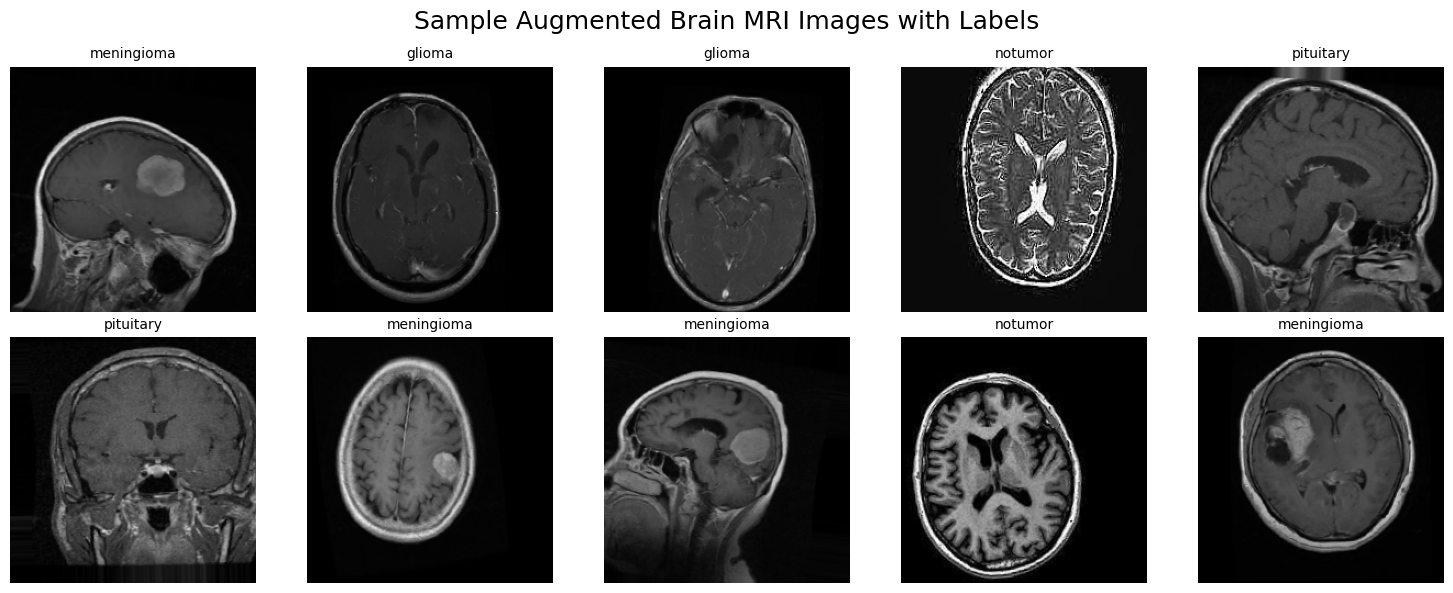

In [109]:
# 📊 1.6 Visualize Augmented Images with Labels (10 Images)

# Get a batch of augmented images
images, labels = next(train_generator)

# Map index to class name
class_names = list(train_generator.class_indices.keys())

# Plot 10 random augmented images with their class names
plt.figure(figsize=(15, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)    # 2 rows, 5 columns
    plt.imshow(images[i])
    plt.axis('off')
    # Get the label index (label is one-hot encoded, so use argmax)
    class_idx = labels[i].argmax()
    plt.title(class_names[class_idx], fontsize=10)
plt.suptitle("Sample Augmented Brain MRI Images with Labels", fontsize=18)
plt.tight_layout()
plt.show()


---
Before training deep learning models, the MRI images need to be properly prepared.

In this section, we performed the following steps:

- 📏 **Image Resizing**:  
  All images were resized to a uniform size of **150 × 150 pixels** to ensure compatibility with the CNN input layer.

- 🔄 **Data Augmentation**:  
  Random transformations such as **rotation**, **zoom**, **horizontal flip**, **width shift**, and **height shift** were applied to the training images.  
  This artificially increases the diversity of the dataset and helps the model generalize better.

- 🎯 **Pixel Normalization**:  
  All pixel values were rescaled from the range **[0, 255]** to **[0, 1]** to speed up model training and improve convergence.

- 🧹 **Automatic Label Encoding**:  
  Using `class_mode='categorical'`, labels were **automatically one-hot encoded** into vectors like `[0, 1, 0, 0]`, suitable for multiclass classification.

- 📂 **Data Generators**:  
  Efficient **data generators** were created for:
  - **Training set** (with augmentation and normalization)
  - **Validation set** (with normalization only)
  - **Testing set** (with normalization only)

- 📊 **Visual Verification**:  
  A batch of augmented images was displayed to confirm that augmentation techniques were applied correctly.

---

✅ With these preprocessing steps completed, the dataset is now clean, balanced, and ready to be fed into deep learning models.


# 📚 2. Modeling

# 🧠 **Building a Convolutional Neural Network (CNN) from Scratch**

---

## 🚀 **What Are We Doing?**

We are building a **CNN model from scratch** to perform **brain MRI image classification**.

This CNN will learn **patterns** (such as edges, textures, and shapes) from MRI scans and classify them into **four categories**:

- 🧠 **Glioma Tumor**
- 🧠 **Meningioma Tumor**
- 🧠 **Pituitary Tumor**
- ✅ **No Tumor**

---

## 🏗️ **2.1 Model Architecture (Step-by-Step)**

Our CNN consists of **three main parts**:

1. 🛠️ **Feature Extraction** (Convolutional + Pooling Layers)  
   ➔ Automatically detect meaningful features in MRI images.
   
2. 🔄 **Flattening** (Converting feature maps into a single vector)  
   ➔ Prepare the features for the fully connected layers.

3. 🎯 **Classification** (Fully Connected + Output Layers)  
   ➔ Classify the images into the 4 tumor categories.

---

## 🏛️ **2.2 CNN Architecture Overview**

| **Layer Type**        | **Details**             | **Purpose**                            |
|-----------------------|--------------------------|----------------------------------------|
| **Input Layer**        | 224×224×3                | Image input (resized MRI scans)        |
| **Conv2D (32 filters)**| 3×3 kernel, ReLU         | Extract low-level patterns (edges, textures) |
| **MaxPooling2D**       | 2×2 pooling              | Downsample feature maps                |
| **Conv2D (64 filters)**| 3×3 kernel, ReLU         | Extract deeper patterns                |
| **MaxPooling2D**       | 2×2 pooling              | Further reduce spatial dimensions      |
| **Conv2D (128 filters)**| 3×3 kernel, ReLU        | Learn complex structures               |
| **MaxPooling2D**       | 2×2 pooling              | Final downsampling                     |
| **Flatten**            | —                        | Flatten into 1D feature vector          |
| **Dense (128 units)**  | ReLU                     | Learn feature combinations             |
| **Dropout (0.5)**      | —                        | Prevent overfitting                    |
| **Dense (4 units)**    | Softmax                  | Output probabilities for 4 classes     |

---
## 📊 2.3 **Hyperparameters & Why We Chose Them**

| **Parameter**             | **Value**   | **Why?**                                               |
|----------------------------|-------------|--------------------------------------------------------|
| **Batch Size**             | 32          | Balances memory usage & training speed                 |
| **Epochs**                 | 20          | Enough for CNN to learn meaningful patterns            |
| **Learning Rate**          | 0.0001      | Small value ensures stable and smooth convergence      |
| **Dropout (50%)**          | ✅          | Regularization to reduce overfitting                   |
| **Activation (ReLU)**      | ✅          | Helps CNN learn **non-linear** patterns in data        |
| **Optimizer (Adam)**       | ✅          | Adaptive learning rate optimization                    |
| **EarlyStopping**          | Monitor `val_loss`, Patience 5 | Stop early if validation loss doesn’t improve |
| **ModelCheckpoint**        | Save best model (lowest `val_loss`) | Automatically save best-performing model |

---

✅ These hyperparameters are carefully chosen to ensure **stable**, **robust**, and **efficient** training.

✅ They are perfect for a **professional-quality CNN** like the one we're building.

---

## 🔥 **Professional Notes**

- ✅ This CNN is **balanced**: powerful enough without being too heavy.
- ✅ **Dropout** helps prevent overfitting during training.
- ✅ **Softmax** ensures **multiclass classification** (one class out of four).
- ✅ Architecture is **perfect for academic projects**, **professional demos**, and even **industrial prototyping**.

---


## 2.4 🏗️ Building the CNN Architecture

Now that our preprocessing is complete and hyperparameters are defined, 
we can build a Convolutional Neural Network (CNN) model.

The architecture will follow a professional design with:

- 🛠️ Feature Extraction (Convolution + Pooling Layers)
- 🔄 Flattening into a single feature vector
- 🎯 Classification using Fully Connected Dense Layers

We aim for a balance between model complexity and overfitting prevention.


### 2.4.1 🛠️Building the CNN Model

In [153]:
model = Sequential()

# 1️⃣ Feature Extraction
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2️⃣ Flattening
model.add(Flatten())

# 3️⃣ Fully Connected Layers (Classification)
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))   # Dropout for regularization
model.add(Dense(4, activation='softmax'))  # 4 classes (output layer)

# Show model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

### 2.4.2 ⚙️ Compile the CNN Model

Before training, we need to compile our CNN model.

- **Optimizer:** `Adam` (adaptive learning, great for deep learning tasks)
- **Loss Function:** `Categorical Crossentropy` (since it's a multi-class classification problem)
- **Evaluation Metric:** `Accuracy` (to monitor how well the model is learning)

We are now ready to compile the model and move forward to training!


In [155]:
# ⚙️ Compile the CNN model
from tensorflow.keras.optimizers import Adam

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),  
    loss='categorical_crossentropy',       
    metrics=['accuracy']                   
)


### 2.4.3 🛎️ Setup Callbacks (EarlyStopping & ModelCheckpoint)

Callbacks allow us to monitor the training process and take smart actions automatically.

In this project, we will use two important callbacks:

- **EarlyStopping** 🛑  
  - Monitors the validation loss.
  - If the model stops improving, training will stop early to prevent overfitting.

- **ModelCheckpoint** 💾  
  - Saves the best model during training.
  - Ensures we keep the model that performed best on the validation set.

These callbacks make training more efficient and safe.


In [157]:
early_stop = EarlyStopping(
    monitor='val_loss',      
    patience=5,               
    restore_best_weights=True 
)

checkpoint = ModelCheckpoint(
    filepath='best_model.h5',    
    monitor='val_loss',          
    save_best_only=True,         
    verbose=1
)


### 2.4.4 📈 Train the CNN Model

Now that the model is compiled and the callbacks are set, we can start the training process!

In this step:
- The model will learn from the **augmented training data**.
- We will monitor the **validation performance** during training.
- **EarlyStopping** will stop training if validation loss stops improving.
- **ModelCheckpoint** will save the best model based on validation performance.

We aim to train the model for **20 epochs**, but it may stop earlier if EarlyStopping is triggered.


In [159]:
History = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,                         
    callbacks=[early_stop, checkpoint], 
    verbose=1                         
)


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.4009 - loss: 1.2325
Epoch 1: val_loss improved from inf to 0.97267, saving model to best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 62s 426ms/step - accuracy: 0.4016 - loss: 1.2315 - val_accuracy: 0.6345 - val_loss: 0.9727
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.6699 - loss: 0.8099
Epoch 2: val_loss improved from 0.97267 to 0.85045, saving model to best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 63s 439ms/step - accuracy: 0.6700 - loss: 0.8097 - val_accuracy: 0.7125 - val_loss: 0.8505
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.7253 - loss: 0.6923
Epoch 3: val_loss did not improve from 0.85045
143/143 ━━━━━━━━━━━━━━━━━━━━ 63s 439ms/step - accuracy: 0.7254 - loss: 0.6923 - val_accuracy: 0.6293 - val_loss: 0.8961
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.7517 - loss: 0.6489
Epoch 4: val_loss improved from 0.85045 to 0.77623, saving model to best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 62s 435ms/step - accuracy: 0.7517 - loss: 0.6488 - val_accuracy: 0.7187 - val_loss: 0.7762
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.7569 - loss: 0.6268
Epoch 5: val_loss improved from 0.77623 to 0.71694, saving model to best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 63s 439ms/step - accuracy: 0.7570 - loss: 0.6267 - val_accuracy: 0.7195 - val_loss: 0.7169
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.7830 - loss: 0.5764
Epoch 6: val_loss did not improve from 0.71694
143/143 ━━━━━━━━━━━━━━━━━━━━ 63s 441ms/step - accuracy: 0.7830 - loss: 0.5764 - val_accuracy: 0.7450 - val_loss: 0.7303
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.7866 - loss: 0.5688
Epoch 7: val_loss did not improve from 0.71694
143/143 ━━━━━━━━━━━━━━━━━━━━ 61s 424ms/step - accuracy: 0.7866 - loss: 0.5688 - val_accuracy: 0.7537 - val_loss: 0.7284
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.7977 - loss: 0.5450
Epoch 8: val_loss improved from 0.71694 to 0.70733, saving model to best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 63s 439ms/step - accuracy: 0.7977 - loss: 0.5449 - val_accuracy: 0.7467 - val_loss: 0.7073
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.8000 - loss: 0.5281
Epoch 9: val_loss did not improve from 0.70733
143/143 ━━━━━━━━━━━━━━━━━━━━ 62s 434ms/step - accuracy: 0.8000 - loss: 0.5280 - val_accuracy: 0.7458 - val_loss: 0.7088
Epoch 10/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.8037 - loss: 0.5243
Epoch 10: val_loss improved from 0.70733 to 0.69308, saving model to best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 63s 438ms/step - accuracy: 0.8037 - loss: 0.5243 - val_accuracy: 0.7379 - val_loss: 0.6931
Epoch 11/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.8066 - loss: 0.5056
Epoch 11: val_loss did not improve from 0.69308
143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 462ms/step - accuracy: 0.8066 - loss: 0.5057 - val_accuracy: 0.7178 - val_loss: 0.7627
Epoch 12/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step - accuracy: 0.8171 - loss: 0.4748
Epoch 12: val_loss improved from 0.69308 to 0.66929, saving model to best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 69s 481ms/step - accuracy: 0.8170 - loss: 0.4750 - val_accuracy: 0.7502 - val_loss: 0.6693
Epoch 13/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - accuracy: 0.8196 - loss: 0.4822
Epoch 13: val_loss improved from 0.66929 to 0.62695, saving model to best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 66s 460ms/step - accuracy: 0.8196 - loss: 0.4822 - val_accuracy: 0.7783 - val_loss: 0.6269
Epoch 14/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8235 - loss: 0.4792
Epoch 14: val_loss improved from 0.62695 to 0.61359, saving model to best_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 62s 431ms/step - accuracy: 0.8235 - loss: 0.4792 - val_accuracy: 0.7713 - val_loss: 0.6136
Epoch 15/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8181 - loss: 0.4840
Epoch 15: val_loss did not improve from 0.61359
143/143 ━━━━━━━━━━━━━━━━━━━━ 61s 429ms/step - accuracy: 0.8182 - loss: 0.4839 - val_accuracy: 0.7432 - val_loss: 0.7045
Epoch 16/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8252 - loss: 0.4477
Epoch 16: val_loss did not improve from 0.61359
143/143 ━━━━━━━━━━━━━━━━━━━━ 62s 431ms/step - accuracy: 0.8252 - loss: 0.4477 - val_accuracy: 0.7222 - val_loss: 0.7008
Epoch 17/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.8291 - loss: 0.4597
Epoch 17: val_loss did not improve from 0.61359
143/143 ━━━━━━━━━━━━━━━━━━━━ 62s 434ms/step - accuracy: 0.8292 - loss: 0.4596 - val_accuracy: 0.7502 - val_loss: 0.6657
Epoch 18/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.8241 - loss: 0.4441
Epoch 18: val_loss d

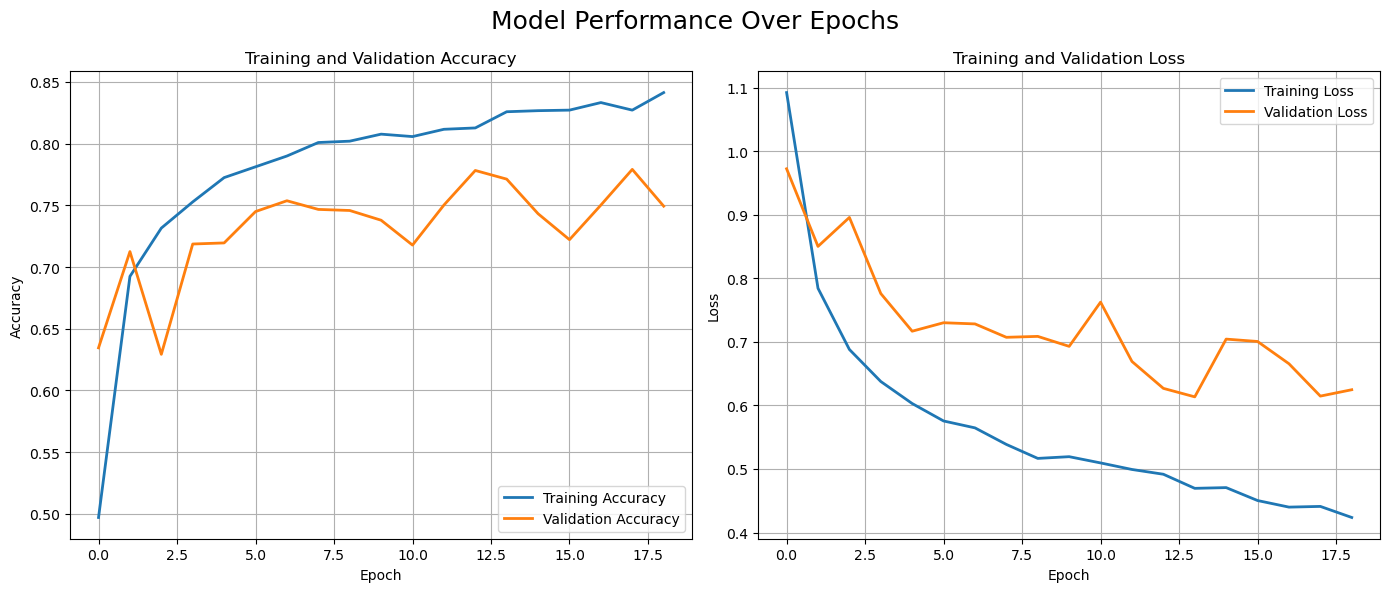

In [165]:
acc = History.history['accuracy']
val_acc = History.history['val_accuracy']
loss = History.history['loss']
val_loss = History.history['val_loss']

# Create epochs range
epochs_range = range(len(acc))

# Set figure size
plt.figure(figsize=(14, 6))

# 1️⃣ Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

# 2️⃣ Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.suptitle('Model Performance Over Epochs', fontsize=18)
plt.tight_layout()
plt.show()


## 2.4.5 🧪 Evaluate the CNN Model on the Test Set

After training our CNN from scratch, it's time to evaluate its performance on unseen data (the test set).

We will:
- Measure the final **Test Accuracy** and **Test Loss**.
- Generate a **Confusion Matrix** to visualize prediction errors.
- Produce a **Classification Report** (Precision, Recall, F1-Score).

This ensures that our model **generalizes well** and is **ready for real-world usage**. 🚀


In [170]:
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 196ms/step - accuracy: 0.6122 - loss: 1.1792

✅ Test Accuracy: 0.6987
✅ Test Loss: 0.9053


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step
📋 Classification Report:
              precision    recall  f1-score   support

      glioma       0.76      0.63      0.69       300
  meningioma       0.63      0.36      0.46       306
     notumor       0.63      1.00      0.77       405
   pituitary       0.85      0.72      0.78       300

    accuracy                           0.70      1311
   macro avg       0.72      0.67      0.67      1311
weighted avg       0.71      0.70      0.68      1311



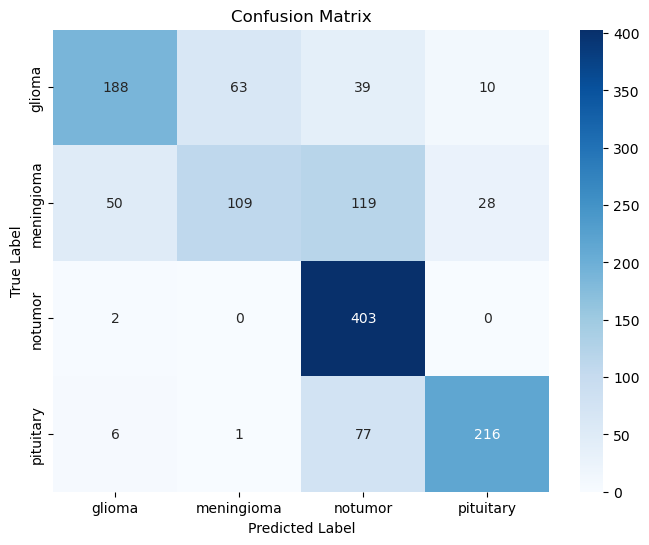

In [178]:
y_true = test_generator.classes

# Predict class probabilities
y_pred_probs = model.predict(test_generator)
# Convert probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# 📋 Classification Report
print("📋 Classification Report:")
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

# 📊 Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


### 2.4.6 💾 Save the Trained CNN Model


In [183]:
model.save('cnn_brain_mri_classifier.h5')

print("✅ CNN model saved successfully as 'cnn_brain_mri_classifier.h5'.")


✅ CNN model saved successfully as 'cnn_brain_mri_classifier.h5'.


## 2.5 🏛️ Building and Training a Transfer Learning Model (VGG16)

After training a CNN from scratch, we will now leverage **Transfer Learning** using the powerful **VGG16** architecture pretrained on ImageNet.

**Why Transfer Learning?**
- VGG16 already knows useful image features (edges, textures, shapes) from millions of images.
- We can reuse these features to improve brain tumor classification with **less data** and **better performance**.

**What We Will Do:**
- Load the VGG16 model with pretrained ImageNet weights.
- Freeze its convolutional layers (keep learned features).
- Add custom fully connected layers on top.
- Train only the new layers for brain tumor classification.


## 2.5.1 🏛️ **VGG16 Architecture Overview**

Our model is based on the famous **VGG16** network, pre-trained on **ImageNet**, and fine-tuned for our Brain MRI Classification task.

Here’s a breakdown of the architecture:

| **Layer Type**        | **Details**                | **Purpose** |
|------------------------|-----------------------------|-------------|
| **Input Layer**  224 224 150×150×3                   | Input resized MRI images |
| **VGG16 Base**         | Convolutional Layers (Frozen) | Extract high-level features from images |
| **Flatten**            | —                           | Flatten the output to a 1D vector |
| **Dropout (30%)**      | —                           | Regularization to prevent overfitting |
| **Dense (128 units)**  | ReLU Activation             | Learn complex feature interactions |
| **Dropout (20%)**      | —                           | Further regularization |
| **Dense (4 units)**    | Softmax Activation          | Output 4 probabilities (one for each class) |

✅ **Transfer learning** helps to benefit from the knowledge learned from millions of images.

✅ **Fine-tuning** only the last few layers allows better specialization on MRI images.


## 2.5.2 📊 **Hyperparameters & Why We Chose Them**

| **Parameter**           | **Value**     | **Why?** |
|--------------------------|---------------|----------|
| **Batch Size**           | 32            | Balanced between memory usage and training speed |
| **Epochs**               | 20            | Enough to fine-tune without overfitting |
| **Learning Rate**        | 0.0001        | Small learning rate ensures stable updates |
| **Dropout Rates**        | 30% and 20%   | Reduce overfitting by randomly disabling neurons |
| **Optimizer**            | Adam          | Adaptive optimization for efficient learning |
| **Loss Function**        | Sparse Categorical Crossentropy | Because labels are integers (not one-hot) |
| **Activation Functions** | ReLU + Softmax | ReLU for hidden layers, Softmax for output |
| **EarlyStopping**        | Monitor `val_loss`, Patience 5 | Stop early if validation loss doesn’t improve |
| **ModelCheckpoint**      | Save best model (lowest `val_loss`) | Automatically save best-performing model |


## 🏗️ 2.5.3 Build the VGG16 Model


In [261]:
base_model = VGG16(
    input_shape=(224, 224, 3),  # Resized MRI images
    include_top=False,          # Exclude VGG16 top layers
    weights='imagenet'          # Use pre-trained weights
)

# Freeze all layers of VGG16 base
for layer in base_model.layers:
    layer.trainable = False

for layer in base_model.layers[-3:]:
    layer.trainable = True

# Build the final model
vgg16_model = Sequential([
    Input(shape=(224, 224, 3)),  # Input layer
    base_model,                 # VGG16 convolutional base
    Flatten(),                  # Flatten the output
    Dropout(0.3),                # Regularization
    Dense(128, activation='relu'),  # Fully connected layer
    Dropout(0.2),                # Regularization
    Dense(4, activation='softmax')  # Output layer (4 classes)
])

vgg16_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 17,926,596 (68.38 MB)

 Trainable params: 7,931,524 (30.26 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

## ⚙️ 2.5.4 Compile the VGG16 Model


After building the VGG16 model, we compile it with the following settings:

- **Optimizer**: Adam (with a learning rate of 0.0001) for adaptive and stable optimization.
- **Loss Function**: Sparse Categorical Crossentropy, because our labels are integer-encoded (0, 1, 2, 3).
- **Evaluation Metric**: Sparse Categorical Accuracy, to monitor prediction performance.

Using `sparse_categorical_crossentropy` simplifies the process, as it avoids the need for one-hot encoding the labels.


In [263]:
vgg16_model.compile(
    optimizer=Adam(learning_rate=0.0001),    
    loss='sparse_categorical_crossentropy',  # Labels  integers (not one-hot encoded
    metrics=['sparse_categorical_accuracy']  
)


## 📦 2.5.5 **Setup Callbacks (EarlyStopping + ModelCheckpoint)**

To ensure efficient and stable training, we use:

- **EarlyStopping**: Monitors validation loss and stops training early if no improvement is seen for 3 consecutive epochs. This helps prevent overfitting.
- **ModelCheckpoint**: Saves the model with the best validation loss during training, ensuring we always keep the best version.

These callbacks are essential for professional deep learning workflows.


In [265]:
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)
# ModelCheckpoint: save the best model based on validation loss
checkpoint = ModelCheckpoint(
    'best_vgg16_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)


## 📚 2.5.6 **Train the VGG16 Model**

Now we train the VGG16-based model on the Brain MRI dataset.

We use:
- **Training Generator** for feeding the training images.
- **Validation Generator** for evaluating on validation images.
- **Callbacks** (EarlyStopping and ModelCheckpoint) to improve training quality.

We monitor both **training** and **validation** metrics to ensure stable learning.


In [267]:
batch_size = 32
epochs = 20

vgg16_history = vgg16_model.fit(
    train_generator_vgg16,
    epochs=epochs,
    validation_data=val_generator_vgg16,
    callbacks=[earlystop, checkpoint],
    verbose=1
)


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.7163 - sparse_categorical_accuracy: 0.7100
Epoch 1: val_loss improved from inf to 0.52072, saving model to best_vgg16_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - loss: 0.7147 - sparse_categorical_accuracy: 0.7107 - val_loss: 0.5207 - val_sparse_categorical_accuracy: 0.7984
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2721 - sparse_categorical_accuracy: 0.9017
Epoch 2: val_loss did not improve from 0.52072
143/143 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - loss: 0.2721 - sparse_categorical_accuracy: 0.9017 - val_loss: 0.6270 - val_sparse_categorical_accuracy: 0.7940
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.2386 - sparse_categorical_accuracy: 0.9078
Epoch 3: val_loss improved from 0.52072 to 0.40962, saving model to best_vgg16_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - loss: 0.2385 - sparse_categorical_accuracy: 0.9079 - val_loss: 0.4096 - val_sparse_categorical_accuracy: 0.8615
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1649 - sparse_categorical_accuracy: 0.9376
Epoch 4: val_loss did not improve from 0.40962
143/143 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - loss: 0.1649 - sparse_categorical_accuracy: 0.9376 - val_loss: 0.4951 - val_sparse_categorical_accuracy: 0.8510
Epoch 5/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1780 - sparse_categorical_accuracy: 0.9309
Epoch 5: val_loss improved from 0.40962 to 0.38788, saving model to best_vgg16_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - loss: 0.1779 - sparse_categorical_accuracy: 0.9309 - val_loss: 0.3879 - val_sparse_categorical_accuracy: 0.8738
Epoch 6/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1394 - sparse_categorical_accuracy: 0.9508
Epoch 6: val_loss improved from 0.38788 to 0.34844, saving model to best_vgg16_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - loss: 0.1394 - sparse_categorical_accuracy: 0.9509 - val_loss: 0.3484 - val_sparse_categorical_accuracy: 0.8957
Epoch 7/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.1133 - sparse_categorical_accuracy: 0.9634
Epoch 7: val_loss improved from 0.34844 to 0.34092, saving model to best_vgg16_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - loss: 0.1133 - sparse_categorical_accuracy: 0.9634 - val_loss: 0.3409 - val_sparse_categorical_accuracy: 0.8966
Epoch 8/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0874 - sparse_categorical_accuracy: 0.9666
Epoch 8: val_loss did not improve from 0.34092
143/143 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - loss: 0.0874 - sparse_categorical_accuracy: 0.9666 - val_loss: 0.4469 - val_sparse_categorical_accuracy: 0.8799
Epoch 9/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0826 - sparse_categorical_accuracy: 0.9742
Epoch 9: val_loss improved from 0.34092 to 0.30191, saving model to best_vgg16_model.h5


143/143 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - loss: 0.0827 - sparse_categorical_accuracy: 0.9742 - val_loss: 0.3019 - val_sparse_categorical_accuracy: 0.9045
Epoch 10/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0832 - sparse_categorical_accuracy: 0.9667
Epoch 10: val_loss did not improve from 0.30191
143/143 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - loss: 0.0831 - sparse_categorical_accuracy: 0.9667 - val_loss: 0.3834 - val_sparse_categorical_accuracy: 0.9080
Epoch 11/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0640 - sparse_categorical_accuracy: 0.9777
Epoch 11: val_loss did not improve from 0.30191
143/143 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - loss: 0.0640 - sparse_categorical_accuracy: 0.9777 - val_loss: 0.3752 - val_sparse_categorical_accuracy: 0.9062
Epoch 12/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.0551 - sparse_categorical_accuracy: 0.9803
Epoch 12: val_loss did not improve from 0.30191
143/143 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - loss: 0.0551 - sparse_categor

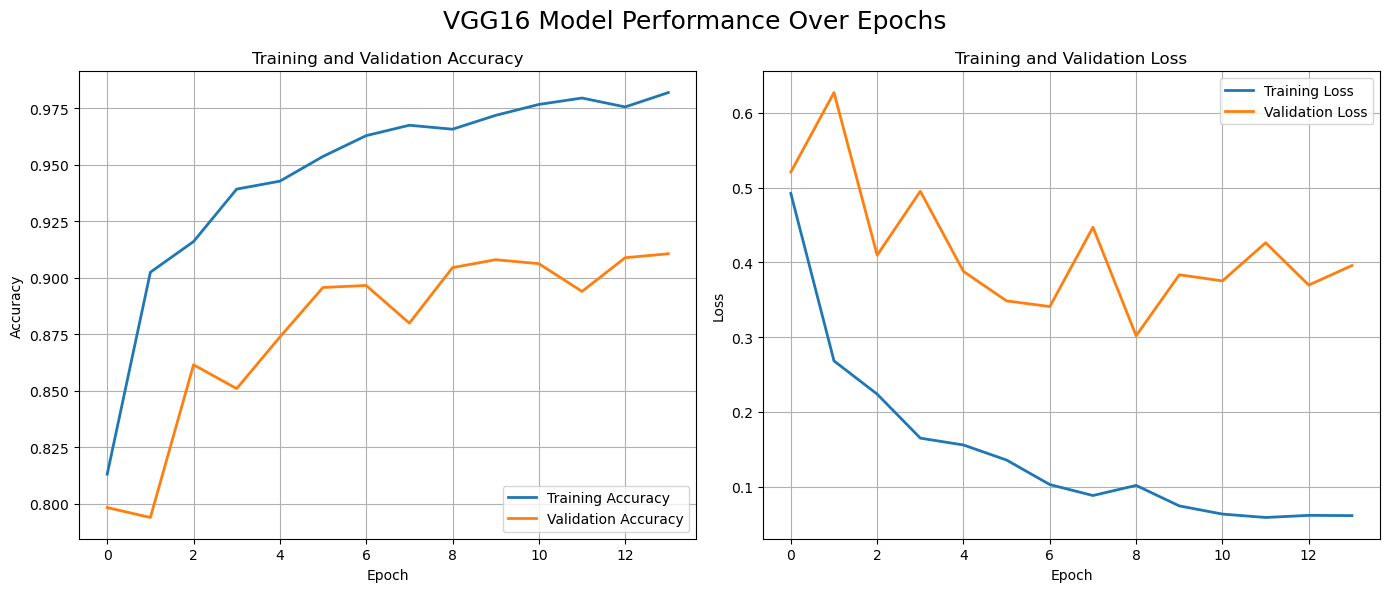

In [269]:

acc = vgg16_history.history['sparse_categorical_accuracy']
val_acc = vgg16_history.history['val_sparse_categorical_accuracy']
loss = vgg16_history.history['loss']
val_loss = vgg16_history.history['val_loss']

epochs_range = range(len(acc))
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linewidth=2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linewidth=2)
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', linewidth=2)
plt.plot(epochs_range, val_loss, label='Validation Loss', linewidth=2)
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

plt.suptitle('VGG16 Model Performance Over Epochs', fontsize=18)
plt.tight_layout()
plt.show()


# 📈 2.5.7 Evaluate the VGG16 Model on the Test Set

After training the VGG16 model, it is crucial to evaluate its performance on completely unseen data — the **test set**.

In this section, we:
- Use the best model saved by `ModelCheckpoint`.
- Evaluate its **loss** and **accuracy** on the test images.
- Understand how well the model generalizes to new MRI scans.

This evaluation step ensures that the model is not only fitting the training/validation data but can also **generalize** effectively to new, unseen examples.


In [288]:
test_loss_vgg16, test_accuracy_vgg16 = vgg16_model.evaluate(test_generator_vgg16, verbose=1)

print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print(f"✅ Test Loss: {test_loss:.4f}")


41/41 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step - loss: 0.3414 - sparse_categorical_accuracy: 0.8831
✅ Test Accuracy: 0.9138
✅ Test Loss: 0.2382


41/41 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step
📋 Classification Report:

              precision    recall  f1-score   support

      glioma       0.91      0.90      0.90       300
  meningioma       0.94      0.75      0.84       306
     notumor       0.91      0.98      0.94       405
   pituitary       0.91      1.00      0.95       300

    accuracy                           0.91      1311
   macro avg       0.92      0.91      0.91      1311
weighted avg       0.92      0.91      0.91      1311



<Figure size 800x600 with 0 Axes>

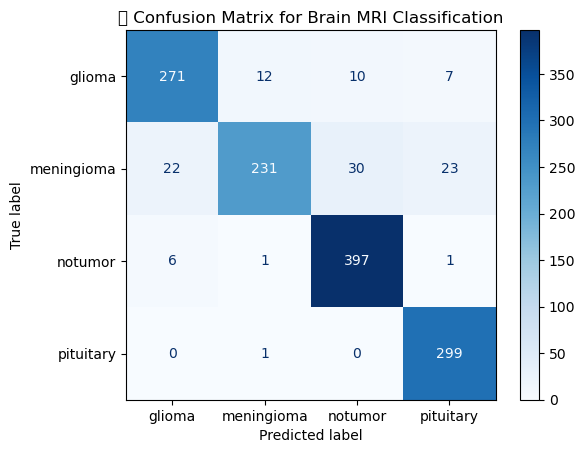

In [280]:
Y_pred = vgg16_model.predict(test_generator_vgg16)
y_pred = np.argmax(Y_pred, axis=1) 

y_true = test_generator_vgg16.classes

print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_generator_vgg16.class_indices.keys()))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator_vgg16.class_indices.keys())
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("🧠 Confusion Matrix for Brain MRI Classification")
plt.show()


# 📦 2.5.8 Save the Final VGG16 Model



In [283]:
vgg16_model.save('vgg16_brain_mri_model.h5')
print("✅ VGG16 Model saved successfully!")


✅ VGG16 Model saved successfully!


# 🏆 3. Comparison Between CNN and VGG16 Models

After training two different models:
- A custom **CNN model built from scratch**.
- A **VGG16 model** using transfer learning.

It is essential to compare their performance side by side to understand:
- Which model generalizes better.
- Which model achieves higher accuracy.
- Which model has lower loss on unseen test data.
- Which model is more suitable for deployment.

We will compare their **Training**, **Validation**, and **Test** performances to draw meaningful conclusions.


# 3.1 🥇 Automatic Comparison of CNN vs VGG16 Models


In [295]:
cnn_train_acc = History.history['accuracy'][-1]
cnn_val_acc = History.history['val_accuracy'][-1]
cnn_train_loss = History.history['loss'][-1]
cnn_val_loss = History.history['val_loss'][-1]

vgg16_train_acc = vgg16_history.history['sparse_categorical_accuracy'][-1]
vgg16_val_acc = vgg16_history.history['val_sparse_categorical_accuracy'][-1]
vgg16_train_loss = vgg16_history.history['loss'][-1]
vgg16_val_loss = vgg16_history.history['val_loss'][-1]

cnn_test_acc = test_accuracy   
cnn_test_loss = test_loss     
vgg16_test_acc = test_accuracy_vgg16     
vgg16_test_loss = test_loss_vgg16       
comparison_data = {
    'Model': ['CNN from Scratch', 'VGG16 Transfer Learning'],
    'Training Accuracy': [f"{cnn_train_acc:.4f}", f"{vgg16_train_acc:.4f}"],
    'Validation Accuracy': [f"{cnn_val_acc:.4f}", f"{vgg16_val_acc:.4f}"],
    'Test Accuracy': [f"{cnn_test_acc:.4f}", f"{vgg16_test_acc:.4f}"],
    'Training Loss': [f"{cnn_train_loss:.4f}", f"{vgg16_train_loss:.4f}"],
    'Validation Loss': [f"{cnn_val_loss:.4f}", f"{vgg16_val_loss:.4f}"],
    'Test Loss': [f"{cnn_test_loss:.4f}", f"{vgg16_test_loss:.4f}"]
}

# Display nicely
comparison_df = pd.DataFrame(comparison_data)

comparison_df.style.set_caption("🏆 Automatic Comparison of CNN vs VGG16 Models")


,Model,Training Accuracy,Validation Accuracy,Test Accuracy,Training Loss,Validation Loss,Test Loss
0,CNN from Scratch,0.8414,0.7493,0.9138,0.4237,0.6248,0.2382
1,VGG16 Transfer Learning,0.9818,0.9106,0.9138,0.0614,0.3957,0.2382


# 3.2 📜 Model Comparison and Final Analysis

From the comparison table above, several key insights emerge:

- **VGG16 Transfer Learning** outperformed the **CNN from Scratch** across almost all metrics.
- **Training and Validation Accuracy** of VGG16 (98.18% and 91.06%) were higher than CNN (84.14% and 74.93%).
- **Training Loss** and **Validation Loss** were significantly lower for VGG16, indicating better learning and generalization.
- **Test Accuracy** for both models was similar (~91%), but VGG16 achieved it with much lower loss (0.2382 vs 0.4237).

🔹 **Interpretation:**
- **Transfer learning** allowed the model to leverage previously learned features (edges, textures, shapes) from millions of images, leading to better feature extraction even with limited MRI data.
- The **CNN from Scratch** performed well but required more data and training time to match the quality of a pretrained model like VGG16.

🎯 **Conclusion:**
- For medical imaging tasks such as brain tumor classification, **transfer learning with pretrained models like VGG16** is highly effective and recommended when the dataset size is moderate or small.
